### IMPORT LIBRARIES

In [44]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, roc_auc_score,
                            classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import scikitplot as skplt
import soundfile as sf
from soundfile import SoundFile
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq, rfftfreq, rfft
import math
import antropy as ant
import seaborn as sns
from scipy.stats import norm, kurtosis
from pedalboard import LadderFilter, Pedalboard
#plt.style.use('dark_background')

### NUMERO DE SAMPLES POR INSTRUMENTO

In [45]:
numSounds = 50

### LOAD KICKS

In [46]:
# OBTAIN KICKS AUDIO SAMPLES
kicksPath = "../InstrumentsClassifier/Instruments/Kicks/"
kicks = []

for i in range(numSounds):
    path = kicksPath + "Kick_" + str(i+1) + ".wav"
    #path = kicksPath + "Bass_Drum_0" + str(i) + "_V01.wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        kicks.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        kicks.append([sound[:,0], sr])

### LOAD SNARES

In [47]:
# OBTAIN SNARE AUDIO SAMPLES
snarePath = "../InstrumentsClassifier/Instruments/Snares/"
snares = []

for i in range(numSounds):
    path = snarePath + "Snare_" + str(i+1) + ".wav"
    #path = snarePath + "SNARE_0" + str(i) + "_01.wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        snares.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        snares.append([sound[:,0], sr])

### LOAD HI HATS

In [48]:
# OBTAIN HIHAT AUDIO SAMPLES
hihatPath = "../InstrumentsClassifier/Instruments/HiHats/"
hihats = []

for i in range(numSounds):
    path = hihatPath + "Hihat_" + str(i+1) + ".wav"
    audio = SoundFile(path)

    if audio.channels == 1:
        sound, sr = sf.read(path)
        hihats.append([sound, sr])
    else:
        sound, sr = sf.read(path)
        hihats.append([sound[:,0], sr])

### FUNCTIONS TO SEE WAVEFORM, SPECTROGRAM AND FFT

In [49]:
def graph_spectrogram(samples, sr, title):    
    plt.figure(figsize=(10,6))
    plt.specgram(samples)
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
def graph_waveform(samples, sr, title):  
    plt.figure(figsize=(10,6))
    plt.plot(samples)
    plt.title(title)
    plt.ylabel('Linear Amplitude')
    plt.xlabel('Time')
    plt.show()

def graph_spectrum(samples, sr, title):
    N = len(samples)
    T = 1/sr
    yf = fft(samples)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

### PLOT AUDIO IN TIME DOMAIN

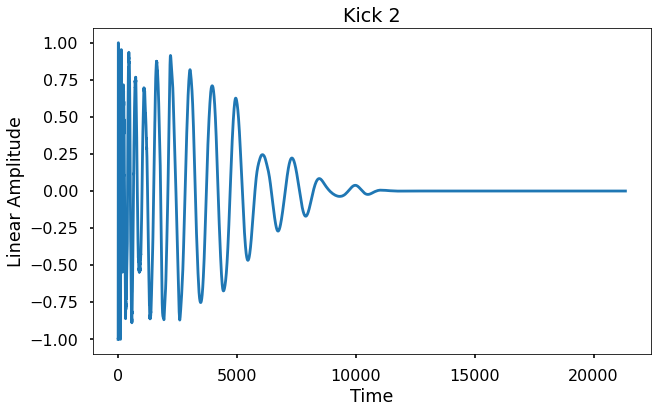

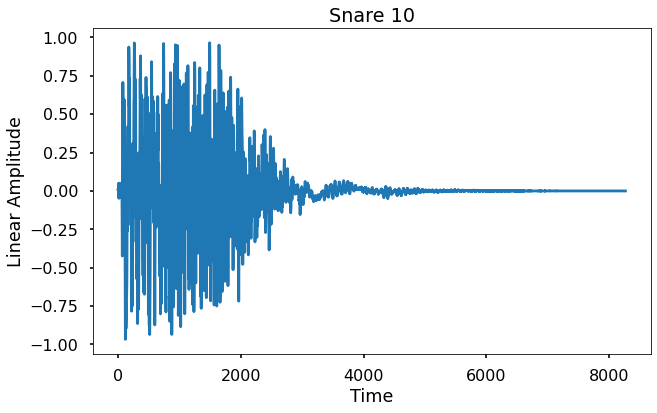

In [50]:
numKick = 2
graph_waveform(kicks[numKick-1][0], kicks[numKick-1][1], "Kick " + str(numKick))

numSnare = 10
graph_waveform(snares[numSnare-1][0], snares[numSnare-1][1], "Snare " + str(numSnare))

### PLOT AUDIO IN FREQUENCY DOMAIN

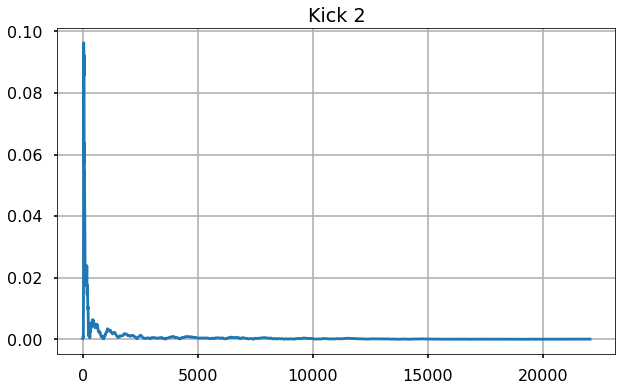

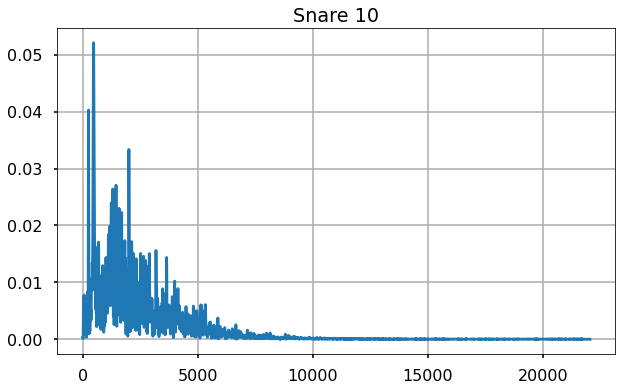

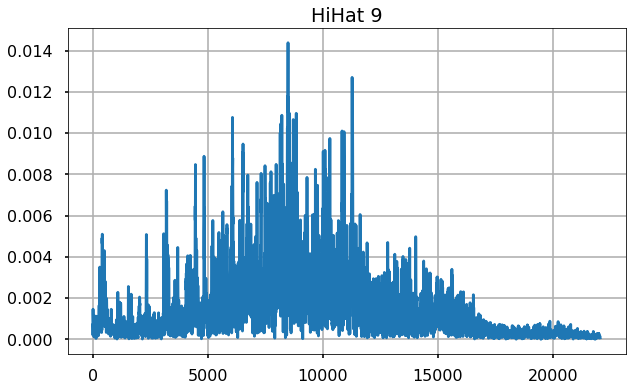

In [51]:
numKick = 2
graph_spectrum(kicks[numKick-1][0], kicks[numKick-1][1], "Kick " + str(numKick))

numSnare = 10
graph_spectrum(snares[numSnare-1][0], snares[numSnare-1][1], "Snare " + str(numSnare))

numHihat = 9
graph_spectrum(hihats[numHihat-1][0], hihats[numHihat-1][1], "HiHat " + str(numHihat))

# PRE PROCESSING

### CALCULATE CENTROID FOR ALL THE SOUNDS

In [52]:
kicks_centroid = []
snares_centroid = []
hihats_centroid = []

cont = 0
for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    kicks_centroid.append(centroid)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    snares_centroid.append(centroid)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    hihats_centroid.append(centroid)

print("Kicks:", kicks_centroid, "\n")
print("Snare:", snares_centroid, "\n")
print("Hihat:", hihats_centroid)

Kicks: [2284.8892175888345, 2362.052887145798, 4167.86485808287, 3424.106537279774, 114.8891739693798, 522.8204335736172, 2970.521222881676, 2062.0550667013094, 1283.3038161260788, 1496.6110525113118, 2203.3263045674425, 1074.8307835469611, 595.0820799255328, 2073.5391901067474, 1329.7777389406644, 983.71205314361, 1118.1923091316178, 1701.565919763427, 1307.1563175671681, 1255.4184498289308, 2566.870339302483, 1478.1876534228368, 1898.2121443396177, 3175.479141652006, 1135.1276970501517, 4415.121910475972, 1963.2500279035503, 2769.2050206297436, 3165.81584501324, 2916.052604050166, 3310.084349227296, 3390.0038445461573, 2998.889726439805, 3190.111920007104, 1850.5061321916476, 3787.1621768338578, 2076.931050251136, 4084.2832303141213, 5089.952749290037, 3456.00720181549, 1025.3665151036612, 2663.2986699853404, 4320.615895101394, 3201.9339182501876, 1591.9715248907114, 4507.396377825369, 2751.9511023759737, 3366.6453902152325, 2619.9555408349206, 2353.543305005407] 

Snare: [3850.00170

### CALCULATE SPREAD

In [53]:
kicks_spread = []
snares_spread = []
hihats_spread = []

def spectralSpread(inFrequency, inAmplitude, inCentroid):
    i = 0
    numerator = 0
    denominator = 0
    for frequency in inFrequency:
        numerator += (frequency - inCentroid) ** 2 * inAmplitude[i]
        denominator += inAmplitude[i]
        i += 1
    return math.sqrt(numerator / denominator)

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    kicks_spread.append(spread)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    snares_spread.append(spread)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    hihats_spread.append(spread)

print("Kicks:", kicks_spread, "\n")
print("Snares:", snares_spread, "\n")
print("HiHat:", hihats_spread)

Kicks: [4254.374655079862, 3896.753264686758, 4945.284351689303, 4233.750465134665, 193.67190739068377, 1567.1581770573946, 3499.43066332103, 3214.868853633649, 2676.48493722306, 2973.142358266635, 3511.3832340779322, 2489.3281154542906, 1449.5396308491388, 3209.750945141707, 3045.3986985038273, 2389.423860748036, 2568.5486073299417, 2968.79529051161, 2635.7250617695972, 2731.088736259569, 4207.598378150281, 3333.529248729086, 3062.8840088843713, 4415.65410765027, 1762.5899745930333, 5044.114665041064, 3286.332787996028, 4397.7932195717785, 4255.69261823594, 4455.048896451653, 4766.319800021247, 4274.378918022106, 4043.887757634037, 4874.0217670939, 3072.4957281728402, 5337.7233702471085, 2862.4962412170935, 5450.617351790098, 4922.734021692149, 4945.046571166031, 2220.5045573728707, 4247.554672758218, 5225.546494424832, 4526.170031369345, 3010.013272495731, 6211.859445227457, 4307.5862685544425, 4914.287776454671, 4204.859695187415, 3662.5246360076267] 

Snares: [3747.90698739801, 344

### CALCULATE AND APPLY FILTERS

In [54]:
def highPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def LowPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.LPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def makeFilters(inSamples, inLow, inHigh):
    inSamples[0] = highPassProcess(inSamples[0], inHigh, inSamples[1])
    inSamples[0] = LowPassProcess(inSamples[0], inLow, inSamples[1])
    return inSamples[0]

cont = 0
for kick in kicks:
    # OBTAIN HIGH AND LOW CUT
    lowCut = kicks_centroid[cont] + kicks_spread[cont]
    highCut = kicks_centroid[cont] - kicks_spread[cont]
    if highCut < 20:
        highCut = 20
    kick[0] = makeFilters(kick, lowCut, highCut)
    cont += 1
    
cont = 0
for snare in snares:
    # OBTAIN HIGH AND LOW CUT
    lowCut = snares_centroid[cont] + snares_spread[cont]
    highCut = snares_centroid[cont] - snares_spread[cont]
    if highCut < 20:
        highCut = 20
    snare[0] = makeFilters(snare, lowCut, highCut)
    cont += 1

cont = 0
for hihat in hihats:
    # OBTAIN HIGH AND LOW CUT
    lowCut = hihats_centroid[cont] + hihats_spread[cont]
    highCut = hihats_centroid[cont] - hihats_spread[cont]
    if highCut < 20:
        highCut = 20
    hihat[0] = makeFilters(hihat, lowCut, highCut)
    cont += 1

# OBTAIN DATA

### OBTAIN MAIN CENTROID

In [55]:
kicks_centroid = []
snares_centroid = []
hihats_centroid = []

cont = 0
for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    kicks_centroid.append(centroid)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    snares_centroid.append(centroid)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    hihats_centroid.append(centroid)

print("Kicks:", kicks_centroid, "\n")
print("Snare:", snares_centroid, "\n")
print("Hihat:", hihats_centroid)

Kicks: [1202.8840978552537, 1379.0790773125898, 2781.0996573253674, 2523.3528502120407, 110.16025798037833, 343.46461614532944, 2440.037564382302, 1551.396234024083, 804.9844307555055, 894.9925079483962, 1557.8125078234614, 605.9252228821425, 386.2855610040237, 1411.3678108308227, 756.1394122026909, 520.4877860316208, 669.7749041242889, 1150.7691581115118, 816.6130207050775, 787.9076037010142, 1541.498043711495, 754.5933485554856, 1338.611771412998, 2090.5997333387877, 873.869648740073, 3084.4939477154976, 1199.6185752593424, 1728.1413621674858, 2087.6543446568307, 1825.5478124028955, 2037.2618471380783, 2392.0950572025536, 2149.1049021978724, 1898.1911489769607, 1229.4856237281008, 2184.9865539018883, 1635.2204315632414, 2537.5778141687924, 4588.783655927884, 2116.879139641591, 596.9399674536351, 1606.0173985820795, 3086.124471790254, 1926.0839260610883, 1029.593294920314, 2750.9376159390495, 1703.6887401100098, 2027.7510781410565, 1706.330325387265, 1612.9085391021124] 

Snare: [3164

### OBTAIN MAIN SPREAD

In [56]:
kicks_spread = []
snares_spread = []
hihats_spread = []

def spectralSpread(inFrequency, inAmplitude, inCentroid):
    i = 0
    numerator = 0
    denominator = 0
    for frequency in inFrequency:
        numerator += (frequency - inCentroid) ** 2 * inAmplitude[i]
        denominator += inAmplitude[i]
        i += 1
    return math.sqrt(numerator / denominator)

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    kicks_spread.append(spread)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    snares_spread.append(spread)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    hihats_spread.append(spread)

print("Kicks:", kicks_spread, "\n")
print("Snares:", snares_spread, "\n")
print("HiHat:", hihats_spread)

Kicks: [2235.740880442597, 2345.7013336342575, 3745.6714729712467, 3033.206879284267, 88.95547750096993, 501.22409632676704, 2728.6141566058145, 2069.7995198246995, 1494.6807323096796, 1650.6325005382726, 2336.0399769576034, 1369.4640468541963, 765.4726493486453, 2119.8670850077674, 1627.0373893580431, 1274.487408747285, 1377.901370874241, 1836.0276903768995, 1619.0510991875806, 1523.408167688068, 2612.9977873680523, 1614.7646832237065, 2054.548481957858, 2861.9558906752336, 1260.57594265604, 3808.609747104849, 2055.72311337828, 2953.114188731925, 2996.5668006857895, 2822.0320884840407, 3112.825000347773, 3191.8696170718063, 3102.1012210901267, 2991.2739054380586, 2111.3307399899427, 3624.745644210825, 2066.565822974538, 3660.124139122725, 4075.680278525292, 3121.2611333455466, 1188.4566025941683, 2409.798406522408, 4044.084524063646, 2944.2537014088957, 1836.35086932348, 4217.88251991087, 2644.059092637365, 3251.112926523, 2756.518301441929, 2370.7916353328983] 

Snares: [2867.6427446

### OBTAIN MAIN PEAK

In [57]:
kicks_peak = []
snares_peak = []
hihats_peak = []

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    kicks_peak.append(peak)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    snares_peak.append(peak)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    hihats_peak.append(peak)
    
    
print("Kicks:", kicks_peak, "\n")
print("Snares:", snares_peak, "\n")
print("HiHat:", hihats_peak)

Kicks: [55.799240826655414, 41.332770982707714, 55.215255706443216, 44.79886225111743, 49.582396402184386, 59.5, 59.64497041420118, 67.34162387173023, 64.71831499161868, 65.6165426747115, 69.5207928885256, 73.5, 70.56122715177656, 64.29784387382287, 69.56155530712569, 68.89959089005573, 67.08790215688637, 63.974482216202055, 73.36646017117965, 67.2701108073104, 46.421052631578945, 41.660941257299896, 41.5, 48.800000000000004, 61.20853080568721, 63.544668587896254, 50.467289719626166, 53.331720885234006, 47.14686623012161, 75.63324538258576, 50.29325513196481, 50.858150736042326, 53.331720885234006, 44.79756203744014, 50.28506271379703, 57.59686547670875, 51.71672421656134, 91.72444220345392, 126.0, 53.999212839462984, 90.42927829536842, 56.011854360711254, 63.996517196343056, 50.56583079914253, 48.9275147928994, 49.66216216216216, 35.75722817703595, 95.02774336044821, 42.0, 49.045412418906395] 

Snares: [741.9115486335586, 462.66666666666663, 189.183547062467, 181.59597164552315, 344.9

### OBTAIN MAIN ZERO CROSSING

In [58]:
kicks_zero_crossing = []
snares_zero_crossing = []
hihats_zero_crossing = []

cont = 0
for kick in kicks:
    zero_crossing = librosa.feature.zero_crossing_rate(kick[0])
    zero_crossing = zero_crossing.mean() * kick[1]
    kicks_zero_crossing.append(zero_crossing)
    
for snare in snares:
    zero_crossing = librosa.feature.zero_crossing_rate(snare[0])
    zero_crossing = zero_crossing.mean() * snare[1]
    snares_zero_crossing.append(zero_crossing)
    
for hihat in hihats:
    zero_crossing = librosa.feature.zero_crossing_rate(hihat[0])
    zero_crossing = zero_crossing.mean() * hihat[1]
    hihats_zero_crossing.append(zero_crossing)
    
print("Kicks:", kicks_zero_crossing, "\n")
print("Snares:", snares_zero_crossing, "\n")
print("HiHat:", hihats_zero_crossing)

Kicks: [3889.8193359375, 2784.9609375, 438.86718749999994, 276.70166015625, 58.95155609631148, 249.3544921875, 592.7783203125, 3495.1728045621658, 212.67361111111111, 17.536021706586826, 918.0536526352612, 146.7962449596774, 268.1169628042035, 323.1869346217105, 244.77195739746094, 368.71197809938525, 275.625, 354.14428710937506, 154.560546875, 356.7228429457721, 155.44281005859375, 3149.4147770579266, 3770.5509957550576, 1268.8639322916665, 2342.168978987069, 311.0981188322368, 165.087890625, 183.3584872159091, 228.9697265625, 216.767578125, 665.13671875, 248.74562230603448, 855.4554332386364, 724.951171875, 423.8641036184211, 248.03059895833334, 157.91015625, 947.4609375, 5371.066006747159, 184.70703125, 787.430087002841, 1066.790771484375, 198.41308593749997, 1707.5830078125, 119.57261029411764, 613.5600029667721, 227.51242897727272, 343.9385930332569, 322.998046875, 153.424072265625] 

Snares: [3117.529296875, 4589.095744680852, 2482.8664679276317, 2320.6748560855262, 4455.69680950

### OBTAIN MAIN CURTOSIS 

In [59]:
kicks_kurtosis = []
snares_kurtosis = []
hihats_kurtosis = []

for kick in kicks:
    kurtosisValue = kurtosis(kick[0], fisher=True)
    kicks_kurtosis.append(kurtosisValue)
    
for snare in snares:
    kurtosisValue = kurtosis(snare[0], fisher=True)
    snares_kurtosis.append(kurtosisValue)
    
for hihat in hihats:
    kurtosisValue = kurtosis(hihat[0], fisher=True)
    hihats_kurtosis.append(kurtosisValue)
    
print("Kicks:", kicks_kurtosis, "\n")
print("Snares:", snares_kurtosis, "\n")
print("Hihats:", hihats_kurtosis)

Kicks: [2.905123234756113, 2.333920215871796, -0.8423076518399029, -0.26907085918003393, 6.37462198999922, 7.297923522934271, 2.540560688029469, 43.97681217599313, 3.4219478843126234, 53.22508699593243, 59.890688050008514, 42.01421903297582, 72.06413368398007, 26.12780880218379, 68.54846322244653, 62.38157061298064, 70.19200752169358, 33.153713296041886, 43.8024552892412, 61.65974605534045, 0.38456651030140865, 4.210294352523592, 3.042701473676698, 1.7643850255557867, 60.724649055552185, 0.5652505345211449, -0.5846121795213914, -0.6698380686306593, -0.17828427173881778, 0.27231210735967926, 0.03213524709029203, -0.1550860150416553, 1.5270256462870044, -0.08329009490631245, -0.08676614054210186, 1.0379210684796076, 0.32309820259662825, 2.7397778481018547, 21.25619536949365, 3.095261442415337, 9.775236451273042, 0.31362791875801976, 1.9960724128582656, 0.6163213327354105, 2.238399048498742, 1.2675473345534503, 2.1462050060185716, 11.204228193254579, 0.6831627485213905, -0.353490737958579

### OBTAIN MAIN ENTROPY

In [60]:
kicks_entropy = []
snares_entropy = []
hihats_entropy = []

for kick in kicks:
    entropyValue = ant.spectral_entropy(kick[0], kick[1], method='welch', normalize=True)
    kicks_entropy.append(entropyValue)
    
for snare in snares:
    entropyValue = ant.spectral_entropy(snare[0], snare[1], method='welch', normalize=True)
    snares_entropy.append(entropyValue)
    
for hihat in hihats:
    entropyValue = ant.spectral_entropy(hihat[0], hihat[1], method='welch', normalize=True)
    hihats_entropy.append(entropyValue)

print("Kicks:", kicks_entropy, "\n")
print("Snares:", snares_entropy, "\n")
print("Hihats:", hihats_entropy)

Kicks: [0.22543798200315324, 0.2331024096955869, 0.23875144786877736, 0.3298524813774597, 0.151924841059259, 0.2201476652776233, 0.2748308546713731, 0.24998630844388128, 0.20197542639028346, 0.17230869679674782, 0.22021769910276853, 0.13676902992188267, 0.1818776398705825, 0.2269388039855684, 0.16011589115184383, 0.15161340392034545, 0.1609673827671078, 0.20810189836053086, 0.1446207500641554, 0.17685110191740092, 0.21658243519915174, 0.14927913011108077, 0.22467478503561422, 0.44437664140444716, 0.21554969556833836, 0.3237754360470999, 0.23164848096147242, 0.20070582314740454, 0.28012951968730027, 0.2542000867686114, 0.28943624823057185, 0.28615270069183824, 0.2581590637086302, 0.28437798337335507, 0.23853733377311004, 0.24084612064285235, 0.26945113812729166, 0.28505861557883894, 0.5093953713651908, 0.25619753851520877, 0.20754564037960083, 0.273089207464545, 0.22275221286317065, 0.2798320927139414, 0.21870874986412142, 0.25454325081156015, 0.34576551305859776, 0.2339885526669193, 0.

### OBTAIN MAIN MFCC

In [61]:
kicks_mfcc = []
snares_mfcc = []
hihats_mfcc = []

mfcc_bands = 6

for kick in kicks:
    mfccValue = librosa.feature.mfcc(kick[0], sr=kick[1], n_mfcc=mfcc_bands)
    kicks_mfcc.append(mfccValue)
    
for snare in snares:
    mfccValue = librosa.feature.mfcc(snare[0], sr=snare[1], n_mfcc=mfcc_bands)
    snares_mfcc.append(mfccValue)
    
for hihat in hihats:
    mfccValue = librosa.feature.mfcc(hihat[0], sr=hihat[1], n_mfcc=mfcc_bands)
    hihats_mfcc.append(mfccValue)

### CREATE DATAFRAME WITH MAIN DATA

In [63]:
cont = 0
filas = []
for i in range(len(kicks)*3):
    fila = []
    
    if i < len(kicks):
        fila.append('kick')
        fila.append(1)
        fila.append(kicks_centroid[i])
        fila.append(kicks_spread[i])
        fila.append(kicks_peak[i])
        fila.append(kicks_zero_crossing[i])
        fila.append(kicks_kurtosis[i])
        fila.append(kicks_entropy[i])
        for mfcc in kicks_mfcc[i]:
            fila.append(mfcc.mean())
    elif i >= len(kicks) and i < (len(kicks)+len(snares)):
        fila.append('snare')
        fila.append(2)
        fila.append(snares_centroid[i-len(kicks)])
        fila.append(snares_spread[i-len(kicks)])
        fila.append(snares_peak[i-len(kicks)])
        fila.append(snares_zero_crossing[i-len(kicks)])
        fila.append(snares_kurtosis[i-len(kicks)])
        fila.append(snares_entropy[i-len(kicks)])
        for mfcc in snares_mfcc[i-len(kicks)]:
            fila.append(mfcc.mean())
    elif i >= (len(kicks)+len(snares)):
        fila.append('hihat')
        fila.append(3)
        fila.append(hihats_centroid[i-(len(kicks)*2)])
        fila.append(hihats_spread[i-(len(kicks)*2)])
        fila.append(hihats_peak[i-(len(kicks)*2)])
        fila.append(hihats_zero_crossing[i-(len(kicks)*2)])
        fila.append(hihats_kurtosis[i-(len(kicks)*2)])
        fila.append(hihats_entropy[i-(len(kicks)*2)])
        for mfcc in hihats_mfcc[i-(len(kicks)*2)]:
            fila.append(mfcc.mean())
    
    filas.append(fila)

datos = pd.DataFrame(filas, columns=['Instrumento', 'ID', 'Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Kurtosis', 'Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6'])

In [64]:
datos

,Instrumento,ID,Centroid,Spread,Peak,Zero Crossing,Kurtosis,Entropy,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6
0,kick,1,1202.884098,2235.740880,55.799241,3889.819336,2.905123,0.225438,-418.859985,55.617363,14.326552,27.830212,19.218025,13.920868
1,kick,1,1379.079077,2345.701334,41.332771,2784.960938,2.333920,0.233102,-441.694000,41.789864,22.071066,23.293015,17.600391,15.893335
2,kick,1,2781.099657,3745.671473,55.215256,438.867187,-0.842308,0.238751,-268.343872,60.107288,16.301254,78.101196,2.534892,48.193573
3,kick,1,2523.352850,3033.206879,44.798862,276.701660,-0.269071,0.329852,-346.934631,81.548958,16.880253,58.349915,31.798344,27.831293
4,kick,1,110.160258,88.955478,49.582396,58.951556,6.374622,0.151925,-472.901855,21.128088,19.386335,16.949331,14.328834,11.956783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,hihat,3,1802.728337,977.141760,1007.081174,2828.679865,1.145737,0.479515,-221.480453,210.924698,-121.079224,-58.058456,-1.133557,-36.153000
146,hihat,3,1874.921216,986.125469,1034.834092,3393.820058,-0.360964,0.447621,-179.856934,204.743973,-139.474396,-58.400417,4.284473,-37.969387
147,hihat,3,7070.389039,3137.350790,6481.572403,9913.608871,32.759714,0.766107,-584.056946,-63.966305,-94.354034,41.740128,-2.082720,11.546474
148,hihat,3,7194.667996,3389.618803,3836.085627,11091.954803,3.159345,0.757505,-361.479767,-99.313301,-107.265213,46.821243,-5.836324,21.597137


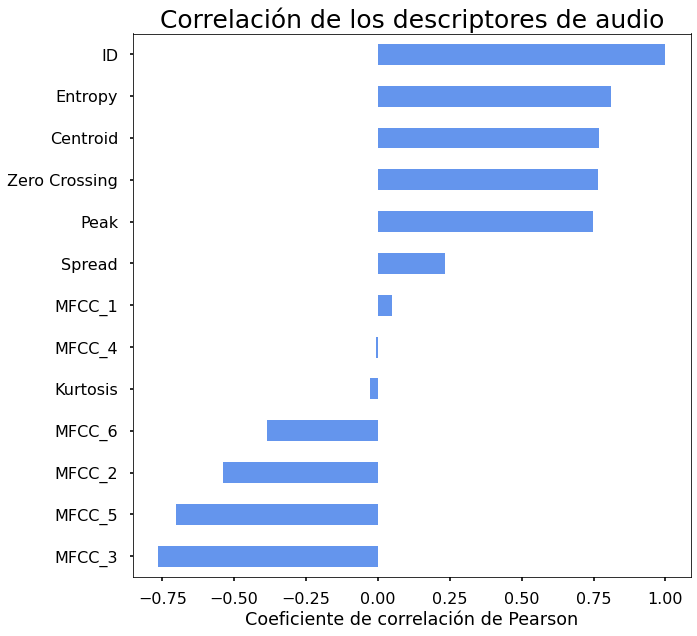

In [65]:
datos.corrwith(datos.ID).sort_values().plot.barh(figsize=(10,10), color='cornflowerblue')
plt.xlabel('Coeficiente de correlación de Pearson')
plt.title('Correlación de los descriptores de audio', fontsize = 25);

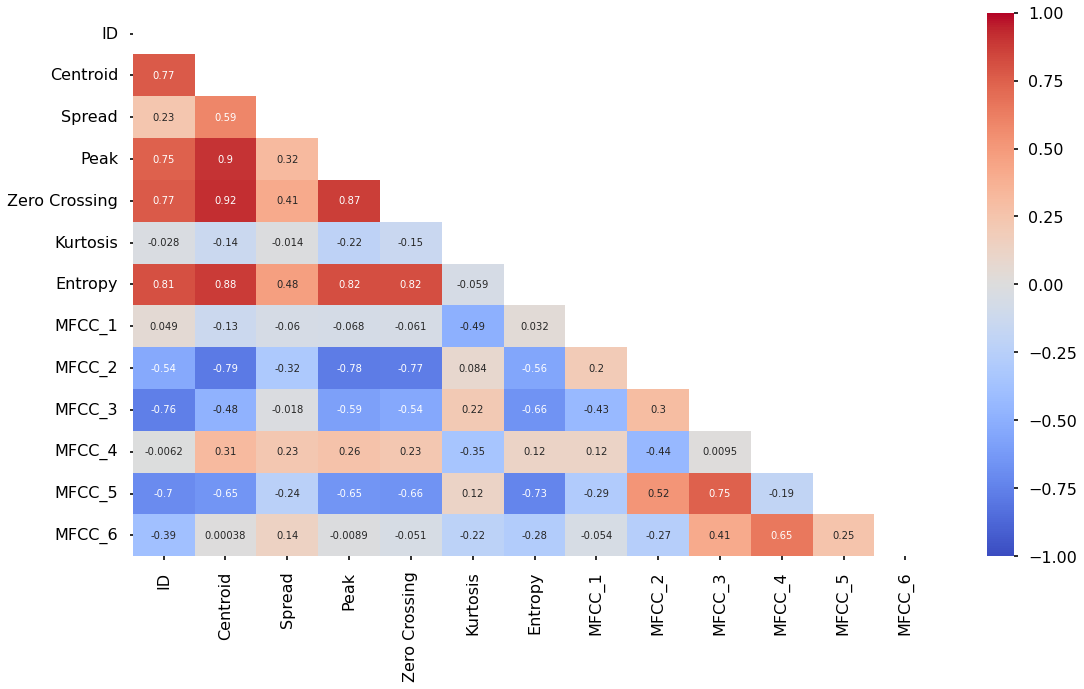

In [66]:
plt.figure(figsize=(18,10))
corr_df = datos.corr()
mask = np.triu(np.ones_like(corr_df))
sns.heatmap(datos.corr(),cmap='coolwarm',annot=True, annot_kws={'fontsize':10}, mask=mask, vmin=-1, vmax=1);

### SEE SOME DATA

In [67]:
plt.style.use("seaborn-poster")

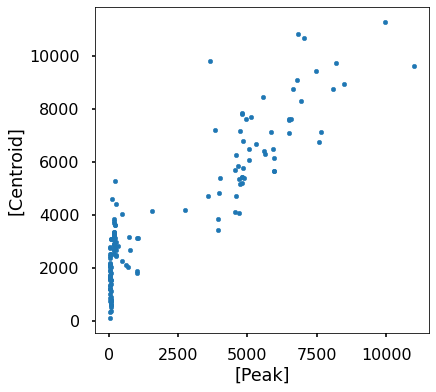

In [68]:
datos[['Peak', 'Centroid']].plot.scatter(x=['Peak'], y=['Centroid'], alpha=1, figsize=(6,6));

### DEFINE X NAMES FOR TRAINING

In [121]:
#x_names = ['Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Kurtosis', 'Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
#           'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']

x_names = ['Centroid', 'Spread', 'Peak', 'Zero Crossing', 'Entropy', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6']

### SPLIT TRAIN AND TEST DATA

In [122]:
x_train, x_test, y_train, y_test = train_test_split(datos[x_names], datos.ID, test_size=0.2, random_state=69)

## TRAIN WITH DECISIONS TREE

In [123]:
model_tree = DecisionTreeClassifier(max_depth=19)
model_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=19)

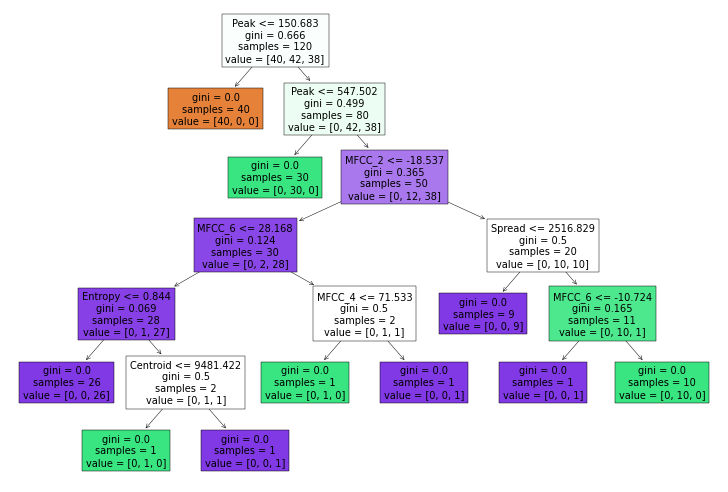

In [124]:
plt.figure()
plot_tree(model_tree, filled=True, feature_names= x_names)
plt.show()

### MAKE AND TEST PREDICTIONS

In [125]:
y_results_tree = model_tree.predict(x_test)

array([1, 3, 1, 3, 1, 1, 2, 2, 3, 1, 3, 3, 1, 2, 3, 2, 2, 3, 2, 3, 3, 2,
       1, 1, 3, 1, 3, 3, 2, 1])

In [126]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0

for num in range(len(x_test)):
    if x_test.index[num] <= 49:
        if y_results_tree[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_tree[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99:
        if y_results_tree[num] == 3:
            hihatAcertados += 1
        numHihat += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihat", hihatAcertados, "predijo como hihat")

De 10 kicks 10 predijo como kick
De 8 Snares 7 predijo como snare
De 12 Hihat 11 predijo como hihat


## TRAIN WITH LOGICTIC REGRESSION

### STANDARIZE DATA

In [127]:
# estandarizado
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

### TRAIN MODEL

In [128]:
# Entrenamiento del modelo
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

### MAKE AND TEST PREDICTIONS

In [134]:
y_results_logictic = model.predict(x_test)

In [130]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0

for num in range(len(x_test)):
    if x_test.index[num] <= 49:
        if y_results_logictic[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_logictic[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99:
        if y_results_logictic[num] == 3:
            hihatAcertados += 1
        numHihat += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihat", hihatAcertados, "predijo como hihat")

De 10 kicks 10 predijo como kick
De 8 Snares 6 predijo como snare
De 12 Hihat 11 predijo como hihat


### PREDICTIONS PROBABILITIES

In [131]:
y_hat_proba = model.predict_proba(x_test)
y_hat_proba[:10]

array([[8.83571115e-01, 3.14857281e-02, 8.49431568e-02],
       [3.25486838e-03, 4.48359661e-01, 5.48385471e-01],
       [8.65498487e-01, 1.30862335e-01, 3.63917846e-03],
       [3.11317693e-04, 4.43570804e-01, 5.56117878e-01],
       [8.00558046e-01, 1.97999867e-01, 1.44208779e-03],
       [7.29646507e-01, 2.68116533e-01, 2.23695990e-03],
       [4.33167393e-01, 5.48074289e-01, 1.87583178e-02],
       [1.79842631e-02, 5.94903403e-02, 9.22525397e-01],
       [8.74253789e-02, 1.30310583e-02, 8.99543563e-01],
       [7.67537848e-01, 2.30018981e-01, 2.44317109e-03]])

In [132]:
print(classification_report(y_test,y_results_logictic))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.86      0.75      0.80         8
           3       0.85      0.92      0.88        12

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



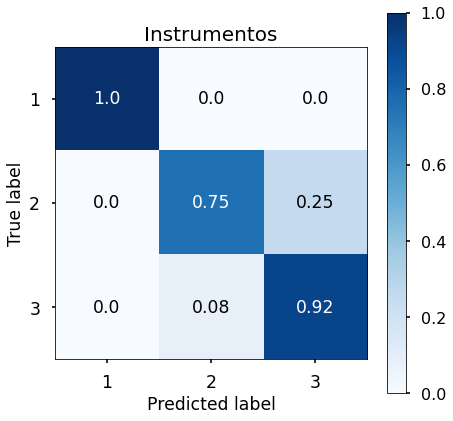

In [133]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_logictic, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [90]:
#print('Área bajo la curva ROC:',"% 1.3f" % roc_auc_score(y_test, y_hat, multi_class='ovr'))